In [2]:
from read_ggp_run import *
from cells_simulation import *
import scipy.stats


In [3]:
def cell_cycle_time(cell):
    new_cell = copy.deepcopy(cell)
    resc = cell.time[-1] - cell.time[0] 
    new_cell.time = (np.array(cell.time) - cell.time[0])/ resc
    return new_cell

def calc_dev(cell_p, cell_true):
    new_cell = copy.deepcopy(cell_p)

    new_cell.log_length = np.array(cell_p.log_length) - np.array(cell_true.log_length)
    new_cell.gfp = np.array(cell_p.gfp) - np.array(cell_true.gfp)
    return new_cell

def plot_binned_stats(ax, time, dev, title, color, bins=10):
    bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(time, dev,  statistic='mean', bins=bins)
    bin_std, _, _ = scipy.stats.binned_statistic(time, dev,  statistic='std', bins=bins)
    bin_centers = bin_edges[1:] - (bin_edges[1] - bin_edges[0])/2

    ax.axhline(0, ls='--', color="black", alpha=0.5)
    ax.plot(time, dev, '.', color="grey", alpha=0.05)

    ax.plot(bin_centers, bin_means, color=color, label=title+" (binned mean with std)")
    ax.fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color=color, alpha=0.2)
    ax.set_ylabel("deviation (prediction-true)")
    ax.set_xlabel("time/cell cycle")
    ax.legend()

def binned_dev(cells_prediction, cells_true, bins=10):
    time = []
    log_length_dev = []
    gfp_dev = [] 

    for i, c in enumerate(cells_true):
        time += list(cell_cycle_time(cells_prediction[i]).time)
        log_length_dev  += list(np.array(cells_prediction[i].log_length) - np.array(cells_true[i].log_length))
        gfp_dev         += list(np.array(cells_prediction[i].gfp) - np.array(cells_true[i].gfp))

    _, ax = plt.subplots(1,2, figsize=(20,5))

    plot_binned_stats(ax[0], time, log_length_dev, "log length", "tab:blue", bins=bins)
    plot_binned_stats(ax[1], time, gfp_dev, "gfp", "tab:orange", bins=bins)

    plt.show()


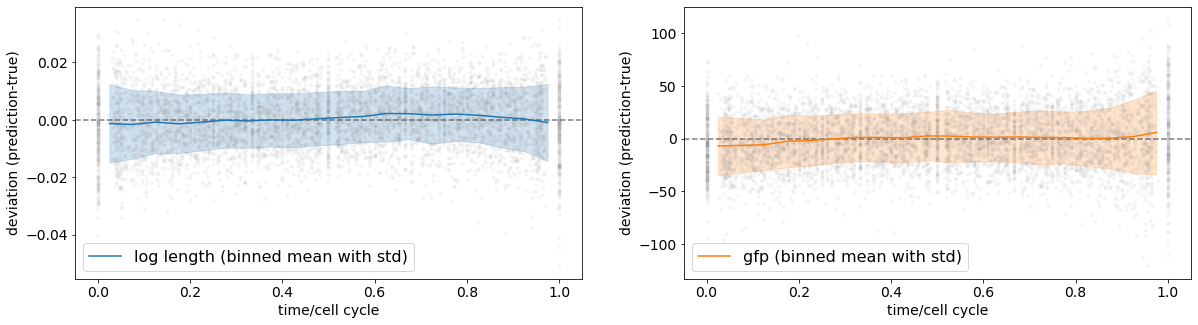

In [4]:
for i in range(1):

    directory = '../data/simulation_set/simulation_set_{:d}'.format(i)
    sample = 'simulation_set_{:d}'.format(i)

    filebase = default_filebase(directory, sample) # default

    dat_file = get_data_file(directory, sample)
    prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)

    indata = pd.read_csv(dat_file)
    prediction = pd.read_csv(prediction_file, skiprows=13)

    cells_true = df2cells(indata, time="time_min", log_length="log_length", gfp="gfp", parent_id=None)
    cells_noise = df2cells(prediction, time="time", log_length="log_length", gfp="fp", parent_id=None)
    cells_prediction = df2cells(prediction, time="time", log_length="mean_x", gfp="mean_g", parent_id=None)
    binned_dev(cells_prediction, cells_true, bins=20)


In [5]:
def var_predictions(cells_prediction, cells_true, bins=10):
    log_length_dev = []
    gfp_dev = [] 
    for i, c in enumerate(cells_true):
        log_length_dev  += list(np.array(cells_prediction[i].log_length) - np.array(cells_true[i].log_length))
        gfp_dev         += list(np.array(cells_prediction[i].gfp) - np.array(cells_true[i].gfp))
    var_log_length_dev = np.var(log_length_dev)
    var_gfp_dev = np.var(gfp_dev)
    return var_log_length_dev, var_gfp_dev

In [6]:
def plot_var_predictions(directory_templ, sample_templ, no=5, x="var_x", xlabel="x"):
    fig, ax = plt.subplots() 
    ax.ticklabel_format(style='sci', scilimits=(-1,2), useOffset=False)

    ax2 = ax.twinx()
    ax2.ticklabel_format(style='sci', scilimits=(-1,2), useOffset=False)

    init = []
    final = []
    final_second = []
    var1 = []
    var2 = []

    for i in range(no):
        directory = directory_templ.format(i)
        sample = sample_templ.format(i)
        filebase = default_filebase(directory, sample) # default

        dat_file = get_data_file(directory, sample)
        prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)

        indata = pd.read_csv(dat_file)
        prediction = pd.read_csv(prediction_file, skiprows=13)

        params_config = read_params_config(prediction_file)
        init.append(get_params_config(params_config, x)["init"].values[0])
        final.append(get_params_config(params_config, x)["final"].values[0])
        if x == "var_g":
            final_second.append(get_params_config(params_config, "var_x")["final"].values[0])
        else:
            final_second.append(get_params_config(params_config, "var_g")["final"].values[0])

        cells_true = df2cells(indata, time="time_min", log_length="log_length", gfp="gfp", parent_id=None)
        cells_prediction = df2cells(prediction, time="time", log_length="mean_x", gfp="mean_g", parent_id=None)
        var_log_length_dev, var_gfp_dev = var_predictions(cells_prediction, cells_true)

        var1.append(var_log_length_dev)
        var2.append(var_gfp_dev)

    c1 = "darkred"
    c2 = "tab:blue"

    sq_init = np.sqrt(np.array(init))
    sq_final = np.sqrt(np.array(final))
    sq_final_second = np.sqrt(np.array(final_second))
    sq_var1 = np.sqrt(np.array(var1))
    sq_var2 = np.sqrt(np.array(var2))


    if x == "var_g":
        ax.scatter(sq_init, sq_var2, color=c1, label="std gfp (prediction - true)")

        # ax.scatter(init, final, color='grey', label="inferred")
        ax.plot(np.linspace(0,sq_init[-1],10), 
                np.linspace(0,sq_init[-1],10), color=c1, ls="--")
        ax2.scatter(sq_init, sq_var1, color=c2, label="std log length (prediction - true)")

        ax.tick_params(axis='y', colors=c1)
        ax2.tick_params(axis='y', colors=c2)

        ax.set_ylabel("gfp")
        ax2.set_ylabel("log length")

        ax.yaxis.label.set_color(c1)
        ax2.yaxis.label.set_color(c2)

        ax.set_ylim([0,np.max(sq_var2)*1.1])
        ax2.set_ylim([0,np.max(sq_var1)*1.1])

    else:
        ax.scatter(sq_init, sq_var1, color=c2, label="std log length (prediction - true)")

        # ax.scatter(init, final, color='grey', label="inferred")
        ax.plot(np.linspace(0,sq_init[-1],10), 
                np.linspace(0,sq_init[-1],10), color=c2, ls="--")
        ax2.scatter(sq_init, sq_var2, color=c1, label="std gfp (prediction - true)")
        
        ax.tick_params(axis='y', colors=c2)
        ax2.tick_params(axis='y', colors=c1)

        ax.set_ylabel("log length")
        ax2.set_ylabel("gfp")
        
        ax.yaxis.label.set_color(c2)
        ax2.yaxis.label.set_color(c1)

        ax.set_ylim([0,np.max(sq_var1)*1.1])
        ax2.set_ylim([0,np.max(sq_var2)*1.1])
    ax.set_xlabel(xlabel)

    fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
    plt.show()

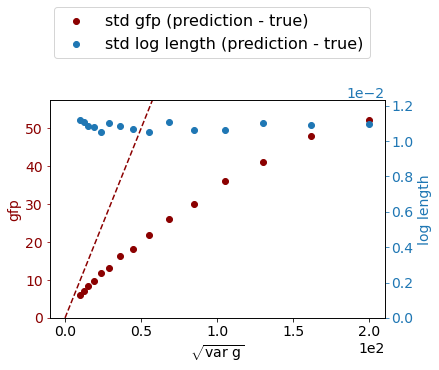

In [7]:
plot_var_predictions('../data/n250_var_g_adder/n250_var_g_adder_{:d}', 'n250_var_g_adder_{:d}', no=15, x="var_g", xlabel=r"$\sqrt{var\ g}$" )

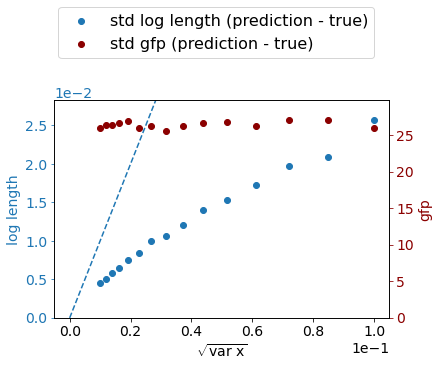

In [8]:
plot_var_predictions('../data/n250_var_x_adder/n250_var_x_adder_{:d}', 'n250_var_x_adder_{:d}', no=15, x="var_x", xlabel=r"$\sqrt{var\ x}$" )

## Cell tree

In [118]:
def get_cell_by_cell_id(cell_list, cell_id):
    for cell in cell_list:
        if cell_id == cell.cell_id:
            return cell 
    return None

def get_cell_by_parent_id(cell_list, parent_id, ignore=None):
    dcells = []
    for cell in cell_list:
        if parent_id == cell.parent_id and cell.parent_id != ignore:
            dcells.append(cell) 
    return dcells + [None, None]


def cell_paths(curr_cell, cell_list):

    def cell_paths_recr(curr_cell, cell_list):
        if curr_cell == None:
            return
        current_path.append(curr_cell)
        dcells = get_cell_by_parent_id(cell_list, curr_cell.cell_id)

        if dcells[0] == None:
            path.append(copy.deepcopy(current_path))
        else:
            cell_paths_recr(dcells[0], cell_list)
            cell_paths_recr(dcells[1], cell_list)
        current_path.pop()

    path = []
    current_path = []
    cell_paths_recr(curr_cell, cell_list)
    return path

def cocanate_cells(cell_list):
    new = copy.deepcopy(cell_list[0])
    new.cell_id = str(new.cell_id )
    for cell in cell_list[1:]:
        new.cell_id += "_"+ str(cell.cell_id)
        new.time = np.append(new.time, cell.time)

        new.log_length = np.append(new.log_length, cell.log_length)
        new.gfp = np.append(new.gfp, cell.gfp)
        new.lt = np.append(new.lt, cell.lt)
        new.qt = np.append(new.qt, cell.qt)
    return new

def cocanate_ggp_cells(cell_list):
    new = copy.deepcopy(cell_list[0])
    new.cell_id = str(new.cell_id )
    for cell in cell_list[1:]:
        new.cell_id += "_"+ str(cell.cell_id)
        new.time = np.append(new.time, cell.time)

        new.log_length = np.append(new.log_length, cell.log_length)
        new.gfp = np.append(new.gfp, cell.gfp)
        new.lt = np.append(new.lt, cell.lt)
        new.qt = np.append(new.qt, cell.qt)

        new.cov_xx = np.append(new.cov_xx, cell.cov_xx)
        new.cov_gg = np.append(new.cov_gg, cell.cov_gg)
        new.cov_ll = np.append(new.cov_ll, cell.cov_ll)
        new.cov_qq = np.append(new.cov_qq, cell.cov_qq)
    return new

In [119]:


def ggp_df2cells(dataset, time="time", 
            log_length="mean_x", gfp="mean_g", 
            lt="mean_l", qt="mean_q",
            cov_xx="cov_xx",
            cov_gg="cov_gg",
            cov_ll="cov_ll",
            cov_qq="cov_qq",
            cell_id="cell_id", 
            parent_id="parent_id"):
    """ 
    dataset (pandas data frame as read from csv file) to list of Cell instances, m
    written for ggp output
    """
    cell_list = []
    last_cell = ""
    for _, row in dataset.iterrows(): 
        if row[cell_id] != last_cell:
            p = row[parent_id]
            lambda0 = row[lt]
            q0 = row[qt]

            new_cell = Cell(row[log_length], row[gfp], 
                        lambda0, q0, 
                        time0=row[time],
                        cell_id=row[cell_id], 
                        parent_id=p)
            cell_list.append(new_cell)
            cell_list[-1].cov_xx = []
            cell_list[-1].cov_gg = []
            cell_list[-1].cov_ll = []
            cell_list[-1].cov_qq = []

        else:
            cell_list[-1].log_length.append(row[log_length])
            cell_list[-1].gfp.append(row[gfp])
            cell_list[-1].time.append(row[time])

            cell_list[-1].lt.append(row[lt])
            cell_list[-1].qt.append(row[qt])

        cell_list[-1].cov_xx.append(row[cov_xx])
        cell_list[-1].cov_gg.append(row[cov_gg])
        cell_list[-1].cov_ll.append(row[cov_ll])
        cell_list[-1].cov_qq.append(row[cov_qq])

        last_cell = row[cell_id]
    return cell_list

# ... starting here

In [170]:
# get files

directory = '../data/test_new_init_n250_var_g_adder/test_new_init_n250_var_g_adder_{:d}'.format(0)
sample = 'test_new_init_n250_var_g_adder_{:d}'.format(0)
filebase = default_filebase(directory, sample) # default

dat_file = get_data_file(directory, sample)
prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)

# read files
indata = pd.read_csv(dat_file)

cells_true = df2cells(indata, time="time_min", log_length="log_length", gfp="gfp", 
                            cell_id="cell_id", parent_id="parent_id", 
                            lt="lt", qt="qt")


prediction = pd.read_csv(prediction_file, skiprows=13)
cells_prediction = ggp_df2cells(prediction, time="time", log_length="mean_x", gfp="mean_g", 
                            cell_id="cell_id", parent_id="parent_id", 
                            lt="mean_l", qt="mean_q")

prediction_f = pd.read_csv(prediction_file_f, skiprows=13)
cells_prediction_f = ggp_df2cells(prediction_f, time="time", log_length="mean_x", gfp="mean_g", 
                            cell_id="cell_id", parent_id="parent_id", 
                            lt="mean_l", qt="mean_q")                          

prediction_b = pd.read_csv(prediction_file_b, skiprows=13)
cells_prediction_b = ggp_df2cells(prediction_b, time="time", log_length="mean_x", gfp="mean_g", 
                            cell_id="cell_id", parent_id="parent_id", 
                            lt="mean_l", qt="mean_q")

cells_noise = df2cells(indata, time="time_min", log_length="log_length_noise", gfp="gfp_noise", 
                            cell_id="cell_id", parent_id="parent_id", 
                            lt="lt", qt="qt")

In [195]:
# paths
paths_true = cell_paths(cells_true[0], cells_true)

paths_prediction = cell_paths(cells_prediction[0], cells_prediction)
paths_prediction_f = cell_paths(cells_prediction_f[0], cells_prediction_f)
paths_prediction_b = cell_paths(cells_prediction_b[0], cells_prediction_b)

paths_noise = cell_paths(cells_noise[0], cells_noise)

## log length and gfp

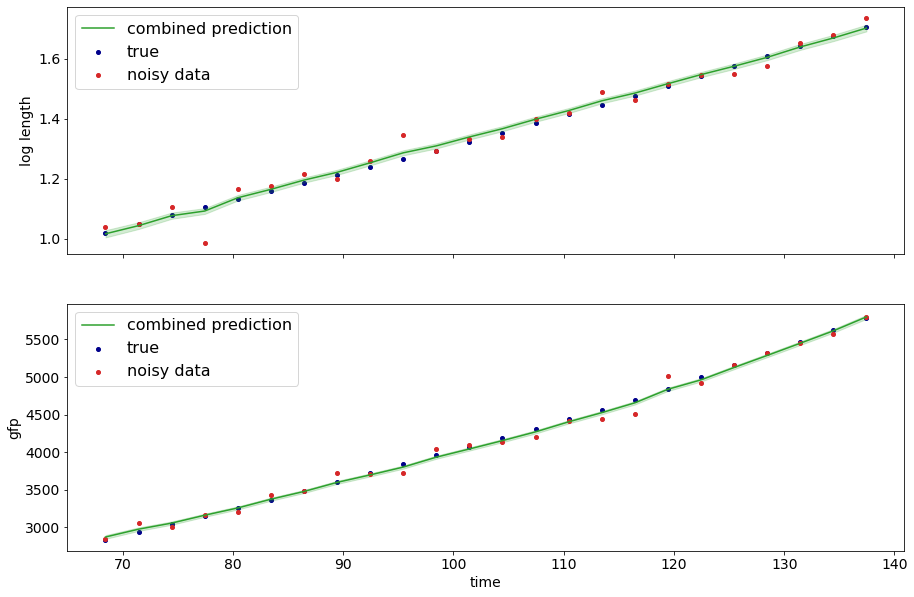

In [201]:
fig, axes = plt.subplots(2,1, figsize=(15,10), sharex=True)
ax = axes.ravel()

start_cell = 1
last_cells=start_cell+1
s=4**2
### Log length
c = "darkblue"
l = "true"
ls = '-'
for cell in paths_true[0][start_cell:last_cells]:
    ax[0].scatter(cell.time, cell.log_length, label=l, color=c, ls=ls, s=s)  
    l = None

c = "tab:green"
l = "combined prediction"
ls = '-'
for cell in paths_prediction[0][start_cell:last_cells]:
    ax[0].fill_between(cell.time, cell.log_length-np.sqrt(cell.cov_xx), cell.log_length+np.sqrt(cell.cov_xx), 
                    color=c, ls=ls, alpha=0.2)
    ax[0].plot(cell.time, cell.log_length, label=l, color=c, ls=ls) 
    l = None

c = "tab:red"
l = "noisy data"
for cell in paths_noise[0][start_cell:last_cells]:
    ax[0].scatter(cell.time, cell.log_length, label=l, color=c, ls=ls, s=s)      
    l = None


### gfp
c = "darkblue"
l = "true"
ls = '-'
for cell in paths_true[0][start_cell:last_cells]:
    ax[1].scatter(cell.time, cell.gfp, label=l, color=c, ls=ls, s=s)  
    l = None

c = "tab:green"
l = "combined prediction"
ls = '-'
for cell in paths_prediction[0][start_cell:last_cells]:
    ax[1].fill_between(cell.time, cell.gfp-np.sqrt(cell.cov_gg), cell.gfp+np.sqrt(cell.cov_gg), 
                    color=c, ls=ls, alpha=0.2)
    ax[1].plot(cell.time, cell.gfp, label=l, color=c, ls=ls) 
    l = None

c = "tab:red"
l = "noisy data"
for cell in paths_noise[0][start_cell:last_cells]:
    ax[1].scatter(cell.time, cell.gfp, label=l, color=c, ls=ls, s=s)      
    l = None

ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('log length')
ax[1].set_ylabel('gfp')

ax[1].set_xlabel('time')    
plt.show()

## Lambda and q

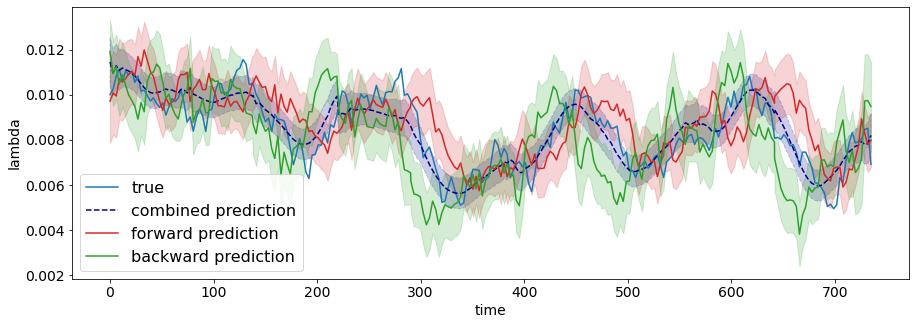

In [125]:

t0, t1 = 0, -1

### all at once
fig, ax = plt.subplots(figsize=(15,5), sharex=True)
for p, l,c, ls in [ (paths_true, "true", "tab:blue", '-'),
                    (paths_prediction, "combined prediction", 'darkblue', '--'), 
                    (paths_prediction_f, "forward prediction", 'tab:red', '-'), 
                    (paths_prediction_b, "backward prediction", 'tab:green', '-')]:
    if l == "true":
        super_cell= cocanate_cells(p[0])
    else: 
        super_cell = cocanate_ggp_cells(p[0])
        ax.fill_between(super_cell.time[t0:t1],
                        super_cell.lt[t0:t1]-np.sqrt(super_cell.cov_ll[t0:t1]), 
                        super_cell.lt[t0:t1]+np.sqrt(super_cell.cov_ll[t0:t1]), 
                        color=c, ls=ls, alpha=0.2)


    ax.plot(super_cell.time[t0:t1], super_cell.lt[t0:t1], label=l, color=c, ls=ls)

ax.set_ylabel('lambda')
ax.set_xlabel('time')

ax.legend()
plt.show()


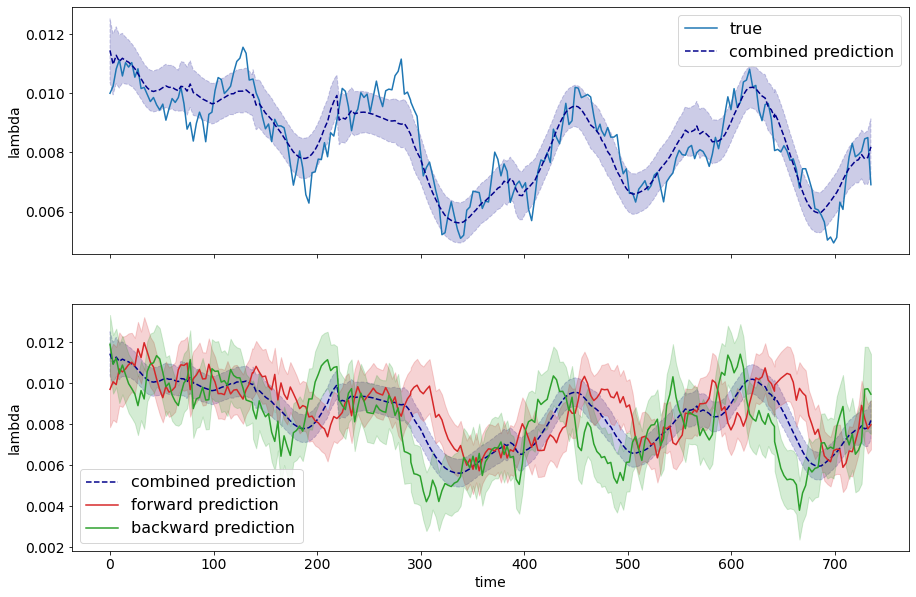

In [128]:
fig, axes = plt.subplots(2,1, figsize=(15,10), sharex=True)
ax = axes.ravel()
t0, t1 = 0, -1

for p, l,c, ls in [(paths_true, "true", "tab:blue", '-'),
            (paths_prediction, "combined prediction", 'darkblue', '--')
            ]:
    if l == "true":
        super_cell= cocanate_cells(p[0])
    else: 
        super_cell = cocanate_ggp_cells(p[0])
        ax[0].fill_between(super_cell.time[t0:t1],
                        super_cell.lt[t0:t1]-np.sqrt(super_cell.cov_ll[t0:t1]), 
                        super_cell.lt[t0:t1]+np.sqrt(super_cell.cov_ll[t0:t1]), 
                        color=c, ls=ls, alpha=0.2)
    ax[0].plot(super_cell.time[t0:t1], super_cell.lt[t0:t1], label=l, color=c, ls=ls)


for p, l,c, ls in [
            (paths_prediction, "combined prediction", 'darkblue', '--'), 
            (paths_prediction_f, "forward prediction", 'tab:red', '-'), 
            (paths_prediction_b, "backward prediction", 'tab:green', '-')]:
    if l == "true":
        super_cell= cocanate_cells(p[0])
    else: 
        super_cell= cocanate_ggp_cells(p[0])
        ax[1].fill_between(super_cell.time[t0:t1],
                        super_cell.lt[t0:t1]-np.sqrt(super_cell.cov_ll[t0:t1]), 
                        super_cell.lt[t0:t1]+np.sqrt(super_cell.cov_ll[t0:t1]), 
                        color=c, ls=ls, alpha=0.2)
    ax[1].plot(super_cell.time[t0:t1], super_cell.lt[t0:t1], label=l, color=c, ls=ls)



ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('lambda')
ax[1].set_ylabel('lambda')

ax[1].set_xlabel('time')
plt.show()


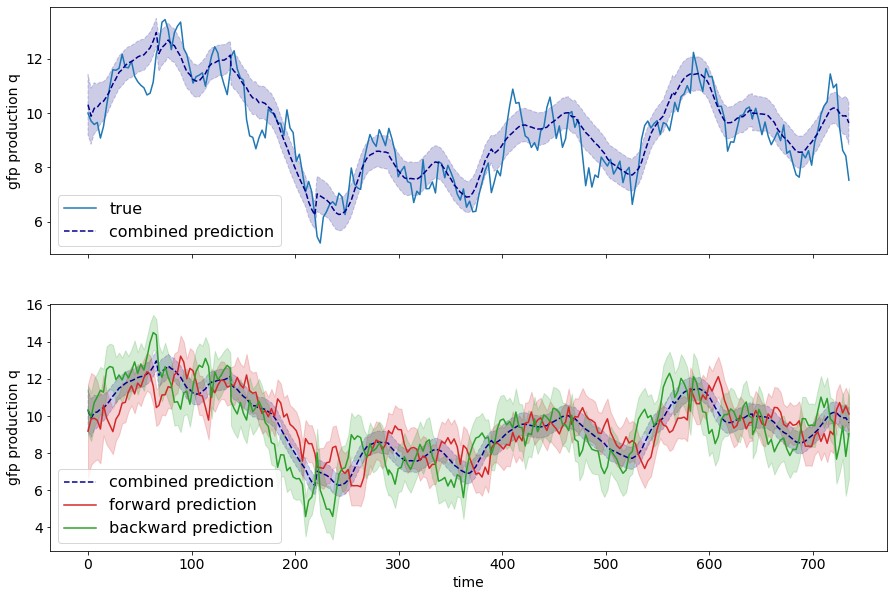

In [130]:
fig, axes = plt.subplots(2,1, figsize=(15,10), sharex=True)
ax = axes.ravel()
t0, t1 = 0, -1

for p, l,c, ls in [(paths_true, "true", "tab:blue", '-'),
            (paths_prediction, "combined prediction", 'darkblue', '--')
            ]:
    if l == "true":
        super_cell = cocanate_cells(p[0])
    else: 
        super_cell = cocanate_ggp_cells(p[0])
        ax[0].fill_between(super_cell.time[t0:t1],
                        super_cell.qt[t0:t1]-np.sqrt(super_cell.cov_qq[t0:t1]), 
                        super_cell.qt[t0:t1]+np.sqrt(super_cell.cov_qq[t0:t1]), 
                        color=c, ls=ls, alpha=0.2)
    ax[0].plot(super_cell.time[t0:t1], super_cell.qt[t0:t1], label=l, color=c, ls=ls)


for p, l,c, ls in [
            (paths_prediction, "combined prediction", 'darkblue', '--'), 
            (paths_prediction_f, "forward prediction", 'tab:red', '-'), 
            (paths_prediction_b, "backward prediction", 'tab:green', '-')]:
    if l == "true":
        super_cell = cocanate_cells(p[0])
    else: 
        super_cell = cocanate_ggp_cells(p[0])
        ax[1].fill_between(super_cell.time[t0:t1],
                        super_cell.qt[t0:t1]-np.sqrt(super_cell.cov_qq[t0:t1]), 
                        super_cell.qt[t0:t1]+np.sqrt(super_cell.cov_qq[t0:t1]), 
                        color=c, ls=ls, alpha=0.2)
    ax[1].plot(super_cell.time[t0:t1], super_cell.qt[t0:t1], label=l, color=c, ls=ls)



ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('gfp production q')
ax[1].set_ylabel('gfp production q')

ax[1].set_xlabel('time')
plt.show()


## Auto-correlations

In [62]:
import scipy.signal

def norm_corr(a, b):
    return (np.mean(a*b) - np.mean(a)*np.mean(b))/(np.std(a)*np.std(b))

def auto_corr(a, taumax, dt=1.):
    auto_corrs = [norm_corr(a, a)]
    for tau in np.arange(1,taumax):
        ac = norm_corr(a[tau:], a[:-tau])
        auto_corrs.append(ac)
    time = [t*dt for t in range(len(auto_corrs))]
    return time, auto_corrs

def correlate(a, b, taumax, dt=1.):
    corrs = [norm_corr(a, b)]
    for tau in np.arange(1,taumax):
        co = norm_corr(a[tau:], b[:-tau])
        corrs.append(co)
    time = [t*dt for t in range(len(corrs))]
    return time, corrs


def linear(x, a, b):
    return a*np.array(x) + b

def plot_auto_corr_paths(paths, taumax, dt, OU="lt", title=""):
    fig, ax = plt.subplots( figsize=(8,6))
    slopes_tau0 = []
    ymin = 1
    for p in paths:
        super_cell = cocanate_cells(p)
        if OU == "lt":
            tau, auto_corrs = auto_corr(super_cell.lt, taumax, dt)
        elif OU == "qt":
            tau, auto_corrs = auto_corr(super_cell.qt, taumax, dt)

        ymin = np.min(list(auto_corrs)+[ymin])
        
        i, j = 0, 1
        slopes_tau0.append((auto_corrs[i] - auto_corrs[j])/(tau[i] - tau[j]))

        p = ax.plot(tau, auto_corrs)
        ax.plot(tau, linear(tau, slopes_tau0[-1], 1), color=p[0].get_color(), ls='--', 
                    label='slope {:.4f}'.format(slopes_tau0[-1]))
    # ax[1].hist(slopes_tau0, bins="auto")
    ax.set_ylim([ymin-0.05, 1.05])
    ax.set_ylabel(r"norm. autocorrelation $R(\tau)$")
    ax.set_xlabel(r"$\tau$")
    ax.set_title(title)
    plt.legend()

    plt.show()

# def plot_auto_corr_cells(cells, taumax, dt, OU="lt"):
#     fig, ax = plt.subplots(1, figsize=(8,6))
#     slopes_tau0 = []
#     for cell in cells:
#         if OU == "lt":
#             tau, auto_corrs = auto_corr(np.array(cell.lt)[:], taumax, dt)
#         elif OU == "qt":
#             tau, auto_corrs = auto_corr(np.array(cell.qt)[20:-20], taumax, dt)

#         ax.plot(tau, auto_corrs)
#         slopes_tau0.append((auto_corrs[0] - auto_corrs[1])/(tau[0] - tau[1]))
#     # ax[1].hist(slopes_tau0, bins="auto")
#     plt.show() 

true,combined
true, forward
true, backward


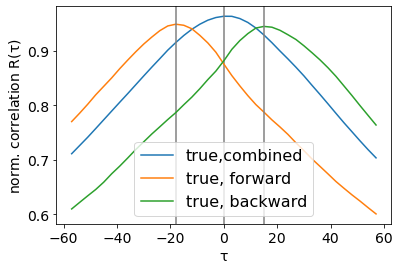

In [54]:
super_cell_true = cocanate_cells(paths_true[0])
super_cell_p = cocanate_cells(paths_prediction[0])
super_cell_pf = cocanate_cells(paths_prediction_f[0])
super_cell_pb= cocanate_cells(paths_prediction_b[0])

for pair, label in [([super_cell_true, super_cell_p] ,"true,combined"), 
            ([super_cell_true, super_cell_pf],"true, forward"), 
            ([super_cell_true, super_cell_pb],"true, backward"), 
            # ([super_cell_pf, super_cell_pb],"forward, backward")
            ]:
    print(label)
    tau_r, corr_r = correlate(pair[0].lt , pair[1].lt, 20, dt=3)
    tau_l, corr_l = correlate(pair[1].lt , pair[0].lt, 20, dt=3)
    tau_l = [ -t for t in tau_l]
    tau = tau_l[::-1]+tau_r
    corr = corr_l[::-1]+corr_r
    plt.plot(tau, corr, label=label)
    plt.axvline(tau[np.argmax(corr)], color="grey")
plt.xlabel(r"$\tau$")
plt.ylabel(r"norm. correlation $R(\tau)$")

plt.legend()
plt.show()

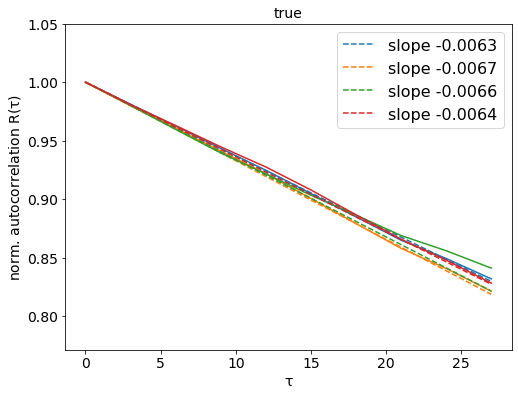

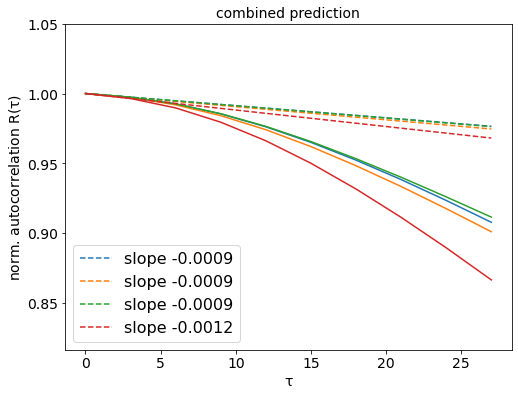

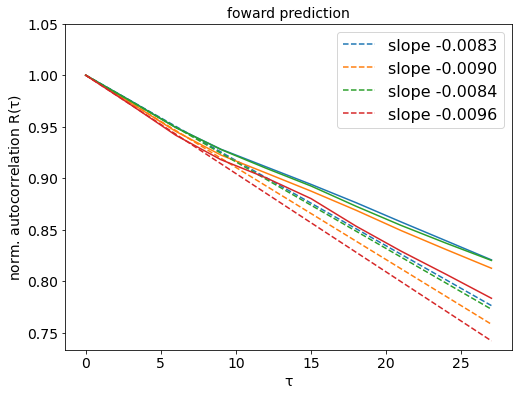

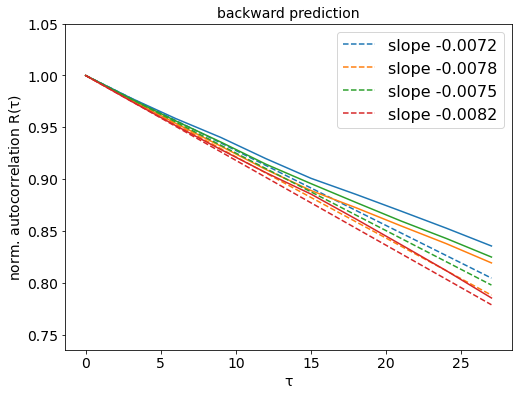

In [55]:
p_indices = [0,1,2,3]
for p, title in [  (paths_true, "true"), 
            (paths_prediction, "combined prediction"), 
            (paths_prediction_f, "foward prediction"), 
            (paths_prediction_b, "backward prediction")]:
    sample_paths = [p[i] for i in p_indices]
    plot_auto_corr_paths(sample_paths, 10, 3, OU="lt", title=title)